In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [1]:
#importing other python files 
import Tide_API as tide
import Depth_profile as depth

In [2]:
#importing required packages
from bs4 import BeautifulSoup
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from rasterio import plot
import math
from datetime import datetime

#machine learning packages 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

#plotting packages
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

In [3]:
#method to get the metadata of the images
def get_metadata(fp):
    #opening file containing metadata
    file = open(fp,"r")
    contents = file.read()
    soup = BeautifulSoup(contents,'xml')
    #getting the time of the image and creating a datetime object 
    dt = (soup.find('SENSING_TIME').text.split('.')[0].replace('T',''))
    dt = datetime.strptime(dt, '%Y-%m-%d%H:%M:%S')
    #getting the coordinates of the reef from depth_profile.py
    _,coords = depth.get_fn_coords(fp.split('/')[1])
    
    #getting the crs of the image 
    geo_info = soup.find('n1:Geometric_Info')
    crs = geo_info.find('HORIZONTAL_CS_CODE').text.lower()
    
    #getting the number of rows and columns in the image 
    rc = geo_info.find('Size' , {'resolution':"10"})
    rows = int(rc.find('NROWS').text)
    cols = int(rc.find('NCOLS').text)
    
    #getting the upper left x and y coordinates 
    geo_pos = geo_info.find('Geoposition' , {'resolution':"10"})
    ulx = int(geo_pos.find('ULX').text)
    uly = int(geo_pos.find('ULY').text)
    
    #getting the step of the image in the x and y dircetions 
    xdim = int(geo_pos.find('XDIM').text)
    ydim = int(geo_pos.find('YDIM').text)

    file.close()
    #storing the metadata in a dictionary 
    meta = {}
    meta['reef_name'] = fp.split('/')[1]
    meta['dt'] = dt
    meta['files'] = get_out_files(meta['reef_name'])
    meta['coords'] = coords
    meta['crs'] = crs
    meta['rows'] = rows
    meta['cols'] = cols 
    meta['ulx'] = ulx
    meta['uly'] = uly
    meta['xdim'] = xdim
    meta['ydim'] = ydim
    
    #getting the latitude and longitude to calculate the tide at the given point 
    lat = (meta['coords'][0] + meta['coords'][1])/2
    lon = (meta['coords'][2] + meta['coords'][3])/2
    #getting the tide on the day of the image 
    meta['tide_level'] = tide.get_tide(lat,lon,meta['dt'])
    #getting a polygon representing the shape of the reef 
    meta['polygon'] = read_gjson(meta)
    return meta

In [4]:
#function to read in the polygon representing the shape of the reef
def read_gjson(meta):
    #creating the filepath for the geojson file 
    fp = os.path.join('data', meta['reef_name'], str(meta['reef_name']) +'.geojson')
    #loading in the geojson file into a geopandas dataframe 
    df = gpd.read_file(fp)
    #setting the current crs of the dataframe 
    df.crs = {'init': 'epsg:4326'}
    #changing the crs to that of the sentinel image 
    df = df.to_crs(meta['crs'])
    return df

In [5]:
#method to read in the outfiles from depth_profile.py on a given reef 
def get_out_files(reef_name):
    #opening the text file 
    path = os.path.join('data',reef_name, str(reef_name) +'.txt')
    f = open(path,"r")
    #creating an empty list 
    files = []
    next_line = -1
    #looping through each line in the file 
    for i,l in enumerate(f):
        #if the line says output files, we want all the lines that come after it 
        if l == 'Output Files:\n':
            while 1 :
                #loop till we meet an empty line or the end of the file 
                line = f.readline()
                if not line or line == '\n': 
                    break 
                #append each filename 
                files.append(line.strip())
    f.close()
    return files

In [6]:
#method to use the depth profiles created from ICESAT 2 data
def prep_df(fp,meta):
    #reading in the depths 
    df = pd.DataFrame.from_csv(fp)
    #adjusting the heights based on the tide on the given day
    df.Height = df.Height - meta['tide_level']
    #converts the lat and lon to the crs of the image 
    df['Coordinates'] = list(zip(df.Longitude, df.Latitude))
    df['Coordinates'] = df.Coordinates.apply(Point)
    df = gpd.GeoDataFrame(df, geometry = 'Coordinates')
    df.crs = {'init': 'epsg:4326'}
    df = df.to_crs(meta['crs'])
    return df

In [7]:
#method to clip the larger sentinel image to a smaller area of interest
def get_bbox(coords,crs):
    #creates a bounding box for just the reef we are interested in 
    ul = (coords[2], coords[1])
    br = (coords[3], coords[0])
    bbox = pd.DataFrame([ul,br], columns = ['Longitude','Latitude'])
    bbox['Coordinates'] = list(zip(bbox.Longitude, bbox.Latitude))
    bbox['Coordinates'] = bbox.Coordinates.apply(Point)
    #converts the coordinates of the bounding box to the crs of the image 
    bbox = gpd.GeoDataFrame(bbox, geometry = 'Coordinates')
    bbox.crs = {'init': 'epsg:4326'}
    bbox = bbox.to_crs(crs)
    return bbox

In [8]:
#method that trains a regression model and returns the same 
def get_regressor(base_fp):
    #gets the metadata 
    fp = os.path.join(base_fp,'MTD_TL.xml')
    meta = get_metadata(fp)
    #creating a training dataset using ICESAT 2 depth profile 
    reef = pd.DataFrame()
    for fn in meta['files']:
        reef = pd.concat([reef,prep_df(fn,meta)])
    #drop any nan rows 
    reef = reef.dropna()
    #gets the bounding box of the reef 
    bbox = get_bbox(meta['coords'], meta['crs'])
    meta['bbox'] = bbox
    #loads in the different band images required 
    imgs = get_images(base_fp,meta)
    meta['imgs'] = imgs
    #creates the masking threshold for band 8 to mask land and clouds 
    b8_pix = (meta['imgs'][3])
    meta['mask_thresh'] = np.median(b8_pix) + (np.std(b8_pix))
    
    #method to get just the pixel values of our bounding box 
    def get_pixel_val(coord):
        x_index = int((coord.x - meta['bbox'].Coordinates.x[0]) // meta['xdim']) 
        y_index = int((coord.y - meta['bbox'].Coordinates.y[0]) // meta['ydim']) 
        return [data[y_index][x_index] for data in imgs]

    #extracts the different band values for our image 
    def extract_pixel_cols(df):
        df['Pixels'] = df.Coordinates.apply(get_pixel_val)
        df['b2'] = df.Pixels.apply(lambda x: (x[0]))
        df['b3'] = df.Pixels.apply(lambda x: (x[1]))
#         df['b4'] = df.Pixels.apply(lambda x: (x[2]))
        df['b8'] = df.Pixels.apply(lambda x: (x[3]))
        #converts points with pixel values above the mask to nan
        df['mask'] = df.b8.apply(lambda x: x if x < meta['mask_thresh'] else np.nan)
        return df

    print(meta['mask_thresh'])
    reef = extract_pixel_cols(reef)
    #drop all rows that are land or clouds 
    reef = reef.dropna(subset = ['mask'])
    
    #stroes the x and y coordinates in individual columns 
    reef['x'] = reef.Coordinates.x
    reef['y'] = reef.Coordinates.y
    #removing training data that are above -2m
    reef = reef.loc[reef.Height < -2]
    
    #gets just the required input columns 
    x = reef.loc[:,['b2','b3']] #,'b4']]

    #subtracts the dark pixel value from each band 
#     bp = (meta['black_val'])
    meta['min_pix'] = {'B02': min(x.b2), 'B03': min(x.b3)}
    bp = meta['min_pix']
    x['b2'] = x['b2'].apply(lambda x: max(1,x - bp['B02']))
    x['b3'] = x['b3'].apply(lambda x: max(1,x - bp['B03']))
    x['diff'] = x.apply(lambda x: (math.log(x['b2']) - math.log(x['b3'])), axis = 1)
#     x['b4'] = x['b4'].apply(lambda x: math.log(max(1,x - bp['B04'])))

    #gets the column that we are trying to predict 
    y = reef.Height
    
    #performs a train test split, putting 33% of the data in the test set
    X_train, X_test, y_train, y_test = train_test_split(x.loc[:,['diff']], y, test_size=0.33, random_state =3)
    from sklearn.model_selection import cross_val_score
    #fit a linear regression ridge model to our data
    from sklearn import linear_model
    reg = linear_model.HuberRegressor()
#     reg = LinearRegression()
    scores = cross_val_score(reg, x.loc[:,['diff']], y, cv=5)
    reg.fit(X_train,y_train)
    
    #predicts values for our test set
    preds = reg.predict(X_test)
    
    print('MSE Test', mean_squared_error(y_test,preds))
    print('MSE Train', mean_squared_error(y_train, reg.predict(X_train)))
    print('Score Test', reg.score(X_test, y_test))
    print('Score Train', reg.score(X_train, y_train))
    print('accuracy', (scores))
    
    print('var original', np.var(y_test.values))
#     print(y_test.values)
    
    print()
#     print(preds)
    print()
#     print(abs(y_test.values - preds))
    print('var residual', np.var(abs(y_test.values - preds)))
    
    #get the different band values and height for all x and y coordinates     
    out = x.copy()
    out['h'] = y
    out['x'] = reef['x']
    out['y'] = reef['y']
#     print(X_train)
    meta['correlation'] = pearsonr(y_train.values, X_train.loc[:,'diff'].values)
    print('corr ', meta['correlation'])
    return reg, meta, out

In [9]:
#method to predict the depth of the rest of the reef 
def predict_reef(reg, meta):
    #creating lists to store required values 
    x = []
    y = []
    h = []

    pix = []
    log_pix = []
    
    #loads in the required images 
    b2_pix = meta['imgs'][0]
    b3_pix = meta['imgs'][1]
#     b4_pix = meta['imgs'][2]
    b8_pix = meta['imgs'][3]
    
    #stores the masking threshold
    mask_thresh = meta['mask_thresh']
    print(mask_thresh)
    
    #looping through the image coordinates 
    for j in range(len(b2_pix)):
        for i in range(len(b2_pix[0])):
            #getting the x and y coordinates 
            x_coord = meta['bbox'].Coordinates.x[0] + ((i)* meta['xdim']) + 5
            y_coord = meta['bbox'].Coordinates.y[0] + ((j)* meta['ydim']) - 5
            p = Point((x_coord, y_coord))
            #checking if the point is within the reef
            if meta['polygon'].loc[0,'geometry'].contains(p):
                #getting the band values minus the dark pixel value 
                bp = meta['black_val']
                bp = meta['min_pix']
                band_2 = max(1,b2_pix[j][i] - bp['B02'])
                band_3 = max(1,b3_pix[j][i] - bp['B03'])
    #             band_4 = math.log(max(1,b4_pix[j][i] - meta['black_val']['B04']))
                band_8 = (b8_pix[j][i])
                #storing the pixel value 
                pix.append([b2_pix[j][i], b3_pix[j][i],b8_pix[j][i]])
                #storing the normalised pixel value 
                log_pix.append([band_2,band_3,band_8])
                #if the band 8 value is higher than the threshold we predict nan for the height 
                if band_8 > mask_thresh:
                    h.append(np.nan)
                    x.append(x_coord)
                    y.append(y_coord)
                    continue
                #else we pass the band values into the regressor and adjust with the tide on the day 
                x.append(x_coord)
                y.append(y_coord)
                x_feat = [math.log(band_2) -  math.log(band_3)]

                h.append(reg.predict([x_feat])[0] + meta['tide_level'])
    #creating a dataframe with the output information and save that df as a csv 
    df = pd.DataFrame([x,y,h,pix,log_pix]).T
    df.columns = ['x','y','height','pixels','normalised_pixel']
#     meta['reef'] = base_fp2.split('/')[1]
    out_fp = os.path.join('data', meta['reef_name'], 'Output', meta['reef_name']+'_out_'+ meta['dt'].strftime("%Y%m%d%H%M%S") + '.csv')
    print(out_fp)
    df.to_csv(out_fp)


In [10]:
#method to load in all the images 
def get_images(base_fp,meta):
    img_time = base_fp.split('/')[2].split('_')[2]
    img_start = base_fp.split('/')[2].split('_')[-2]
    #select the bands that we want 
    bands = ['B02','B03','B04','B08']
    imgs = []
    black = {}
    #loops through the bands 
    for b in bands:
        #creates file path 
        img_path = os.path.join(base_fp, 'IMG_DATA', (img_start + '_' + img_time + '_' + b+ '.jp2'))
        #reads in image 
        band = rasterio.open(img_path, driver = 'JP2OpenJPEG')
        #reads in pixel values 
        img = band.read(1)
        #adds delta to each pixel value, so that we never take log(0)
        delta = 0.0001
        img = np.add(img,delta)
        
        #get the coordinates of the bounding box 
        start_x = meta['bbox'].loc[0,'Coordinates'].x
        start_y = meta['bbox'].loc[0,'Coordinates'].y

        sx = int((start_x - meta['ulx']) // meta['xdim'])
        sy = int((start_y - meta['uly']) // meta['ydim'])

        end_x = meta['bbox'].loc[1,'Coordinates'].x
        end_y = meta['bbox'].loc[1,'Coordinates'].y

        ex = int((end_x - meta['ulx']) // meta['xdim']) 
        ey = int((end_y - meta['uly']) // meta['ydim']) 
        
        #clip the image to the coordinates of the bounding box 
        img = [row[sx:ex] for row in (img[sy:ey])]
        
        #black pixel value is not being used in our code right now, if we do use it we will need to change the coordinates
        #clip a dark pixel corner in the image 
        dark = [x[:500] for x in img[1098:]]
        #use the median as the dark pixel value 
        black_val = np.median(dark)
        black[b] = black_val
        
        
        imgs.append(img)
    #store the dark pixel value in the metadata 
    meta['black_val'] = black
    #return the images
    return imgs

In [11]:
#method to see the relationship between the input variable of our model and the predicted variable 
def band_plots(data):
    import seaborn as sns
    import matplotlib.gridspec as gridspec
    #gets difference between consecutive x values, allowing us to recognise if two tracks are separated
    diffs = np.diff(data.x)
    beams = []
    beam = 1
    for x in abs(diffs):
        beams.append(beam)
        #if the difference is more than 2000, we are working with the next beam 
        if x > 2000:
            beam += 1
    beams.append(beam)
    data['beam'] = beams

    #changing column names
    data['log(band2) - log(band3)'] = data['diff']
    data['Height (m)'] = data.h
    
    #creating jointplot of our data
    g0 = sns.jointplot(data['Height (m)'], data['log(band2) - log(band3)'])
    g0.ax_joint.scatter(data['Height (m)'],data['log(band2) - log(band3)'])


In [12]:
#method to plot the reef depth histogram and a scatter plot of the same 
def plot_reefs(df,data,meta):
    #plot histogram of depths 
    fig, ax = plt.subplots(figsize = (7,7))
    df['height'].plot.hist(bins = np.arange(-30,20,1))
    ax.set_xlabel('Height (m)')
    ax.set_ylabel('Frequency')
    ax.set_title(meta['reef_name'] + ' Depth Histogram')
    
    #plot scatter plot 
    fig,ax = plt.subplots(figsize = (7,7))   
    #getting just depths between +- 45m 
    df = df.loc[(df.height <= 10) & (df.height >= -25)]
    #creating a color scale at 5m intervals 
    print(df.height.max(), df.height.min())
#     if df.height.max() <= 30 and df.height.min() >= -30:
    cmap = cm.colors.ListedColormap(['black','navy','mediumblue' ,'blue','royalblue', 'dodgerblue', 
                                     'skyblue','limegreen',  'lime' , 'yellow'
                                      ,'orange','tomato',
                                     'red','firebrick' ,'maroon'])
    bounds = np.arange(-25,11,2.5)
#     else:
#         cmap = cm.colors.ListedColormap(['black','navy',  'blue','royalblue', 'dodgerblue', 'cornflowerblue',
#                                        'teal',  'aquamarine', 'mediumspringgreen' , 'orange','darkorange', 
#                                          'coral','tomato','orangered','red','firebrick' ,'darkred','maroon'])
#         bounds = np.arange(-45,50,5)
    norm = BoundaryNorm(bounds,cmap.N)
    
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    # create a second axes for the colorbar
    ax2 = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%.1f')

    
    #scatter plot of the predicted depths 
    pts = ax.scatter(x = df.x, y = df.y, c = df.height, s= 1, cmap = cmap, norm = norm)
    #scatter plot of the track lines from the ICESAT 2 data
    ax.scatter(x = data.x, y= data.y, s = 3, c = 'black', label = 'ICESAT-2 tracks')
    custom_lines = [Line2D([0], [0], color='black', lw=4)]
    ax.legend(custom_lines, ['ICESAT-2 tracks'])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(meta['reef_name'] + ' Depth Predictions (m)')

    return 

In [13]:
#creating file paths for all our sentinel images 

base_fp1 = os.path.join('data','Nasau','S2B_MSIL1C_20190715T220929_N0208_R129_T01KCV_20190715T232657.SAFE'\
                  ,'GRANULE','L1C_T01KCV_A012310_20190715T220927')

base_fp2 = os.path.join('data','Nasau','S2B_MSIL1C_20190605T220929_N0207_R129_T01KCV_20190605T233235.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A011738_20190605T220926')

base_fp3 = os.path.join('data','Nasau','S2B_MSIL1C_20190516T220929_N0207_R129_T01KCV_20190516T232309.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A011452_20190516T220927')

base_fp4 = os.path.join('data','Nasau','S2B_MSIL1C_20190215T220919_N0207_R129_T01KCV_20190215T232441.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A010165_20190215T220918')

base_fp5 = os.path.join('data','Nasau','S2B_MSIL1C_20190615T220929_N0207_R129_T01KCV_20190615T232336.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A011881_20190615T220926')

base_fp6 = os.path.join('data','Nasau','S2A_MSIL1C_20190411T220921_N0207_R129_T01KCV_20190411T233352.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A019860_20190411T220920')

base_fp7 = os.path.join('data','Nasau','S2A_MSIL1C_20190809T220921_N0208_R129_T01KCV_20190809T233129.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A021576_20190809T220922')

base_fp8 = os.path.join('data','Nasau','S2B_MSIL1C_20181217T220919_N0207_R129_T01KCV_20181217T232413.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A009307_20181217T220913')

base_fp9 = os.path.join('data','Nasau','S2B_MSIL1C_20181127T220919_N0207_R129_T01KCV_20181127T232403.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A009021_20181127T220914')

base_fp10 = os.path.join('data','Nasau','S2A_MSIL1C_20160327T221002_N0204_R129_T01KCV_20160327T220957.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A003987_20160327T220957')

base_fp11 = os.path.join('data','Nasau','S2B_MSIL1C_20180312T220909_N0206_R129_T01KCV_20180312T232056.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A005303_20180312T220910')

base_fp12 = os.path.join('data','Nasau','S2A_MSIL1C_20180506T220921_N0206_R129_T01KCV_20180509T081504.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A014998_20180506T220921')

base_fp13 = os.path.join('data','Nasau','S2A_MSIL1C_20161023T220912_N0204_R129_T01KCV_20161023T221051.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A006990_20161023T221051')

base_fp14 = os.path.join('data','Nasau','S2B_MSIL1C_20180121T220909_N0206_R129_T01KCV_20180121T231656.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A004588_20180121T220911')


base_fp15 = os.path.join('data','Nasau','S2A_MSIL1C_20161112T220922_N0204_R129_T01KCV_20161112T220917.SAFE'\
                       , 'GRANULE', 'L1C_T01KCV_A007276_20161112T220917')

In [16]:
oil_fp1 = os.path.join('data','One-i-Lau','S2A_MSIL1C_20190411T220921_N0207_R129_T01KCT_20190411T233352.SAFE'\
                       , 'GRANULE', 'L1C_T01KCT_A019860_20190411T220920')
oil_fp2 = os.path.join('data','One-i-Lau','S2B_MSIL1C_20190317T220919_N0207_R129_T01KCT_20190317T233016.SAFE'\
                       , 'GRANULE', 'L1C_T01KCT_A010594_20190317T221058')
oil_fp3 = os.path.join('data','One-i-Lau','S2B_MSIL1C_20181127T220919_N0207_R129_T01KCT_20181127T232403.SAFE'\
                       , 'GRANULE', 'L1C_T01KCT_A009021_20181127T220914')


In [14]:
r,m,d = get_regressor(oil_fp1)
# predict_reef(r,m)

NameError: name 'oil_fp1' is not defined

In [ ]:
r2,m2,d2 = get_regressor(oil_fp2)
# predict_reef(r2,m2)

In [ ]:
r3,m3,d3 = get_regressor(oil_fp3)
# predict_reef(r3,m3)

In [14]:
reg, meta, data = get_regressor(base_fp1)
# predict_reef(reg,meta)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


34.36367359559358
MSE Test 10.540950367942202
MSE Train 18.23086601476318
Score Test 0.353449315480417
Score Train 0.1914302571068912
accuracy [-3.50956438 -0.21026864 -0.10171966 -0.63235141  0.0485273 ]
var original 16.303362783962736


var residual 3.521365946428202
corr  (-0.46708378086170443, 9.291157012996198e-11)


In [15]:
reg2, meta2, data2 = get_regressor(base_fp2)
# predict_reef(reg2,meta2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


792.7392260623869
MSE Test 9.236531766796565
MSE Train 12.438983631353826
Score Test 0.3587526083746868
Score Train 0.5065140894873058
accuracy [-1.3517985  -0.15503901  0.47331848 -0.24780829 -0.03432425]
var original 14.404006764667756


var residual 4.104439730661775
corr  (-0.7224010095427357, 8.147875479565974e-31)


In [16]:
reg3, meta3, data3 = get_regressor(base_fp3)
# predict_reef(reg3,meta3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


979.695227583383
MSE Test 15.712303360373182
MSE Train 23.674487666199475
Score Test -0.0020751147611997034
Score Train -0.03291123482484548
accuracy [-3.30753713 -0.0117816  -0.44277262 -2.714949   -0.0697933 ]
var original 15.679766046398145


var residual 6.628287649922516
corr  (0.029185514053230853, 0.707256526801934)


In [17]:
reg4, meta4, data4 = get_regressor(base_fp4)
# predict_reef(reg4,meta4)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


46.71221545697807
MSE Test 7.874815543934423
MSE Train 37.182743082945386
Score Test 0.5741163219962989
Score Train -0.6630005426853361
accuracy [-1.06764368  0.5022277  -1.28609914  0.02566862 -0.68155057]
var original 18.490531454145064


var residual 3.2226910260523756
corr  (-0.3971791344286436, 1.169438412526791e-07)


In [18]:
reg5, meta5, data5 = get_regressor(base_fp5)
# predict_reef(reg5,meta5)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


782.2959636387467
MSE Test 10.792500028914263
MSE Train 29.677794701242586
Score Test 0.4434960159873429
Score Train -0.3954625076491276
accuracy [-0.83023712  0.61066845 -0.19611403  0.11466546 -7.95060931]
var original 19.393392210951


var residual 6.673682703471635
corr  (-0.4688198985559142, 1.1341207109986409e-10)


In [19]:
reg6, meta6, data6 = get_regressor(base_fp6)
# predict_reef(reg6,meta6)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1014.4247028506709
MSE Test 16.424576472408695
MSE Train 19.25452065691411
Score Test 0.21782111954935246
Score Train 0.13392974897709176
accuracy [-0.0093249  -0.81053622 -0.02677326 -2.21065377 -0.63910078]
var original 20.99849137187874


var residual 8.791802786757755
corr  (-0.4051193910115757, 5.586629140158854e-09)


In [20]:
reg7, meta7, data7 = get_regressor(base_fp7)
# predict_reef(reg7,meta7)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


820.2389995764439
MSE Test 7.204487112917067
MSE Train 32.31744560757095
Score Test 0.6043383643804481
Score Train -0.3806776747120999
accuracy [-1.94811724 -3.45920612  0.10853829  0.58727065 -1.24623904]
var original 18.208707805688125


var residual 2.815651994508728
corr  (-0.430463292191083, 8.759747691237822e-09)


In [21]:
reg8, meta8, data8 = get_regressor(base_fp8)
# predict_reef(reg8,meta8)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


957.6353416806995
MSE Test 10.521307578305523
MSE Train 21.28031915632266
Score Test 0.4198796619689269
Score Train 0.04554858121835936
accuracy [-2.49608686  0.42746223 -0.38048971 -0.10462936 -1.20322164]
var original 18.136422546423407


var residual 4.650206728153493
corr  (-0.4746473568644199, 2.1797832859042835e-11)


In [22]:
reg9, meta9, data9 = get_regressor(base_fp9)
# predict_reef(reg9,meta9)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


909.3798185952959
MSE Test 17.293555190783668
MSE Train 19.887126455777832
Score Test 0.21770311951968968
Score Train 0.08180281720827631
accuracy [-2.3630108  -0.76968594  0.07615345 -2.01711825 -0.21660338]
var original 22.106128277241584


var residual 5.5239313105417995
corr  (-0.3317139578644767, 9.855130154599791e-07)


In [23]:
reg10, meta10, data10 = get_regressor(base_fp10)
# predict_reef(reg10,meta10)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


871.3569427794451
MSE Test 11.0587840974019
MSE Train 9.926443805240902
Score Test 0.48094604984441364
Score Train 0.5440580186726616
accuracy [-1.46658007  0.39015579  0.38716208 -0.57287188  0.1626774 ]
var original 21.30565443936421


var residual 5.38247502052587
corr  (-0.7423404938591784, 1.2487189695147355e-36)


In [24]:
reg11, meta11, data11 = get_regressor(base_fp11)
# predict_reef(reg11,meta11)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


880.9053315394119
MSE Test 9.812129626788881
MSE Train 20.04099353283451
Score Test 0.3298710794506642
Score Train 0.10842403129418265
accuracy [-1.69522302  0.49431669 -0.36916917 -1.47012476 -0.48991156]
var original 14.642152167892446


var residual 4.088752825560587
corr  (-0.4235970653483907, 4.691420434423749e-09)


In [25]:
reg12, meta12, data12 = get_regressor(base_fp12)
# predict_reef(reg12,meta12)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


791.4145976984647
MSE Test 5.107531237603792
MSE Train 8.47699192263656
Score Test 0.7748632778616279
Score Train 0.5927113815140457
accuracy [-0.7684602   0.41797997  0.685189    0.54834056 -0.89614301]
var original 22.686353381589317


var residual 2.2824871113320877
corr  (-0.784541177614277, 1.5086430797502263e-42)


In [26]:
reg13, meta13, data13 = get_regressor(base_fp13)
# predict_reef(reg13,meta13)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1011.4113355399815
MSE Test 45.70336923563693
MSE Train 16.849288034285692
Score Test -1.2221078304563653
Score Train 0.21041504445589865
accuracy [-3.76217216  0.07419945  0.03216091 -2.11503479 -8.10544632]
var original 20.567574898582034


var residual 30.716567310875842
corr  (-0.48646052142073204, 1.9300281971776886e-12)


In [27]:
reg14, meta14, data14 = get_regressor(base_fp14)
# predict_reef(reg14,meta14)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


1107.4896180740243
MSE Test 14.261396443315965
MSE Train 20.4943517568196
Score Test 0.25814624515743545
Score Train 0.10224942419899297
accuracy [ 0.02314942  0.43373418 -0.01707636 -0.22467596 -6.81761957]
var original 19.22399981158349


var residual 9.550631635954705
corr  (-0.6756881620937746, 1.9985876622428123e-28)


In [28]:
reg15, meta15, data15 = get_regressor(base_fp15)
# predict_reef(reg15,meta15)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


827.8435789423553
MSE Test 16.214143478982603
MSE Train 23.012652446752952
Score Test -0.010048958706338151
Score Train -0.02122992864625539
accuracy [-3.82877197 -0.03729651 -0.52239853 -2.98834858 -0.18765878]
var original 16.05282926062271


var residual 5.773614537501826
corr  (-0.12155833598927795, 0.11540097680730657)


In [29]:
datum = [data, data2, data3,data4,data5,data6,data7,data8,data9,data10,data11,data12,data13,data14,data15]
r = [reg, reg2, reg3,reg4,reg5,reg6,reg7,reg8,reg9,reg10,reg11,reg12,reg13,reg14,reg15]
meta_data= [meta, meta2, meta3,meta4,meta5,meta6,meta7,meta8,meta9,meta10,meta11,meta12,meta13,meta14,meta15]
# oil_data = [d,d2,d3]

In [30]:
for i,m_data in enumerate(datum):
    m_data['day'] = [i+1] * len(m_data)
    
# for i,m_data in enumerate(oil_data):
#     m_data['day'] = [i+1] * len(m_data)

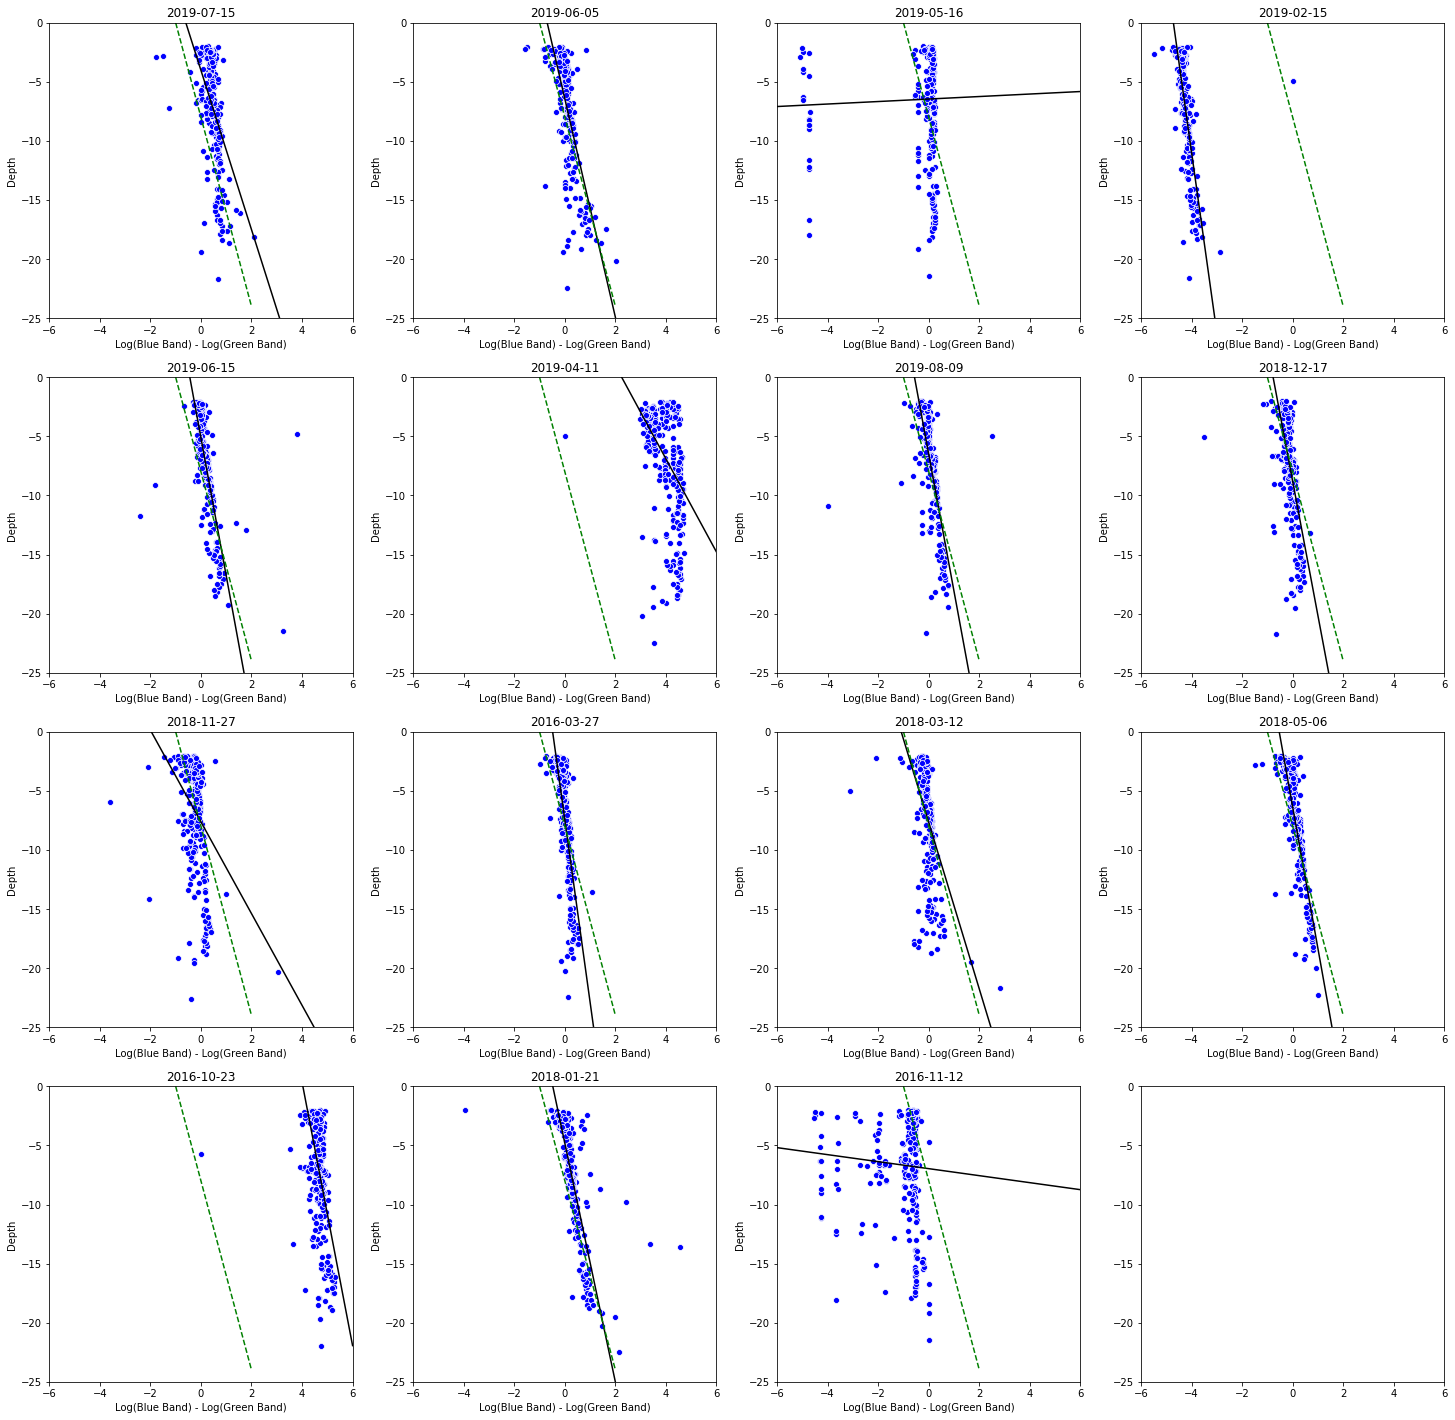

In [34]:
fig, ax = plt.subplots(4,4, figsize = (25,25))
xlim = (-6, 6)
ylim = ( -25,0)

plt.setp(ax, xlim=xlim, ylim=ylim)

axlist = []
for axl in ax:
    for axl2 in axl:
        axlist.append(axl2)

for i,m in enumerate(zip(datum,r)):
    corr_plot(m[1],m[0],axlist[i],meta_data[i]['dt'])

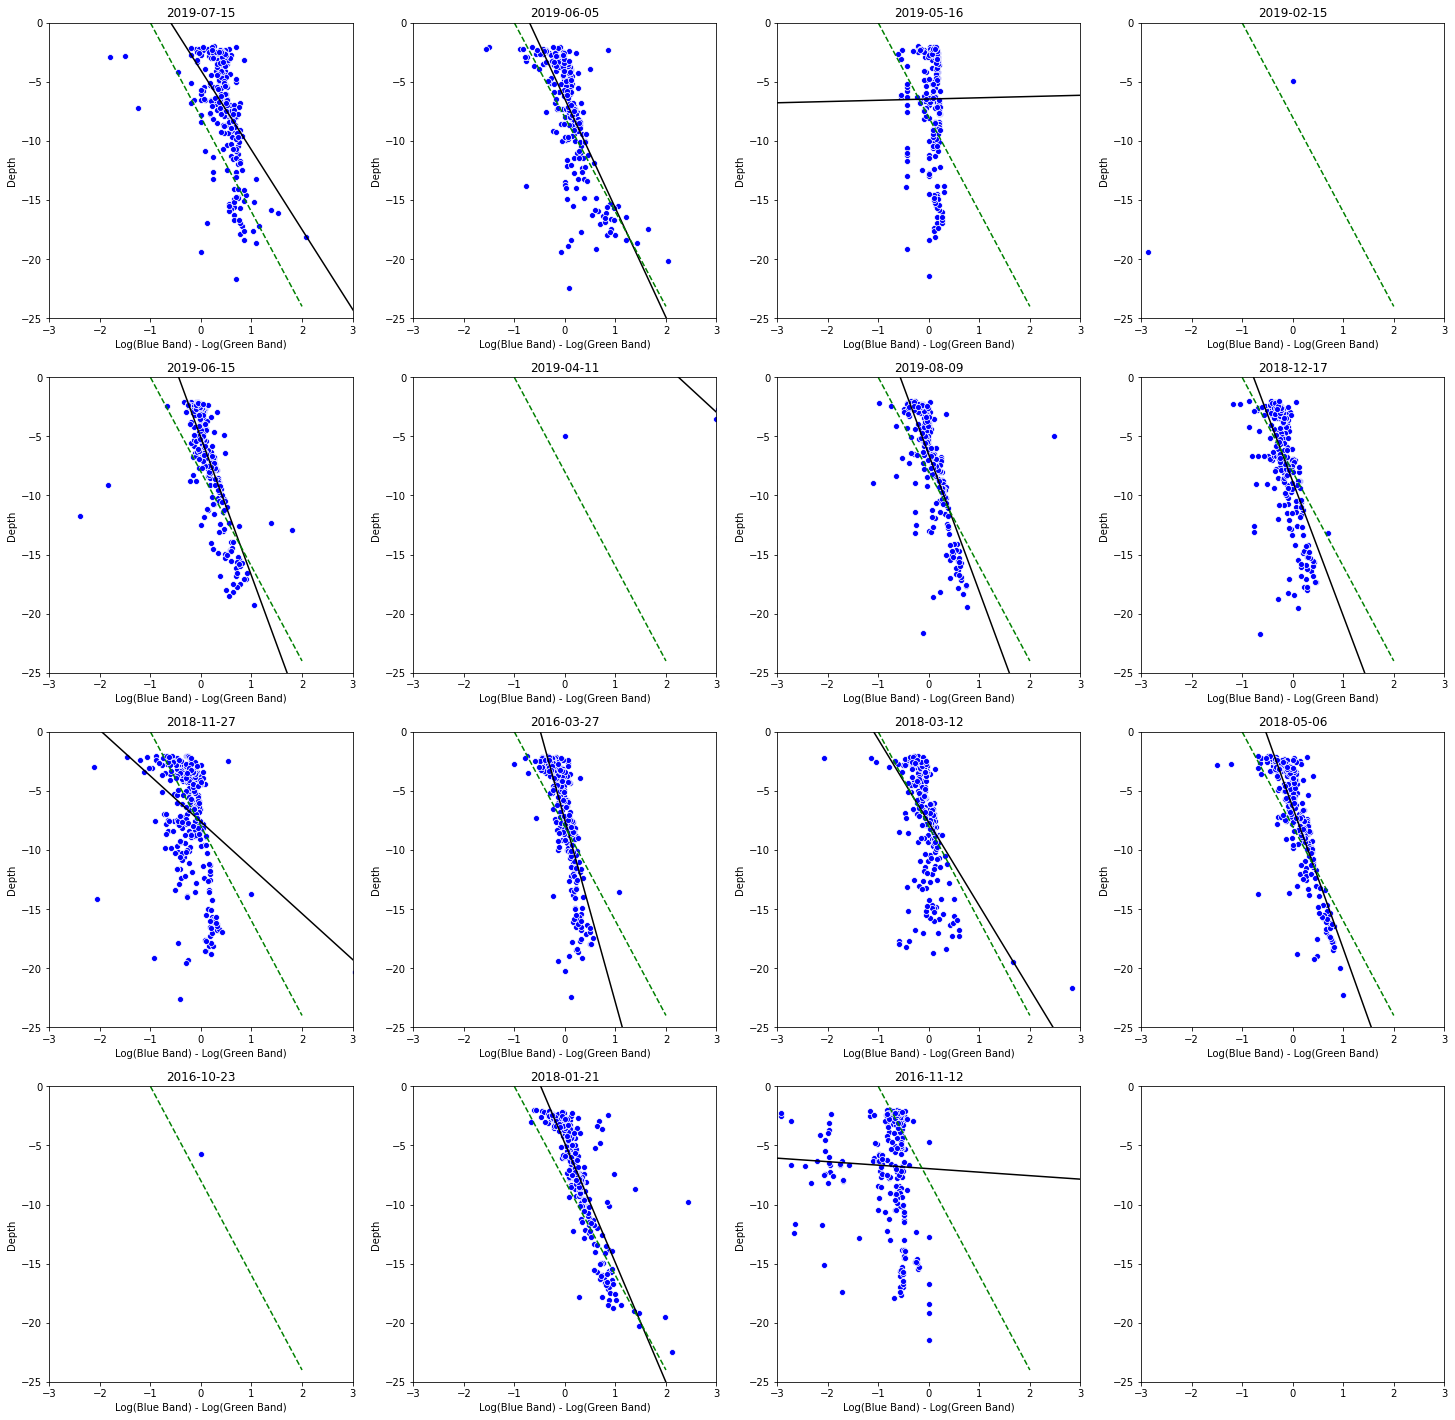

In [35]:
fig, ax = plt.subplots(4,4, figsize = (25,25))
xlim = (-3, 3)
ylim = ( -25,0)

plt.setp(ax, xlim=xlim, ylim=ylim)

axlist = []
for axl in ax:
    for axl2 in axl:
        axlist.append(axl2)

for i,m in enumerate(zip(datum,r)):
    corr_plot(m[1],m[0],axlist[i],meta_data[i]['dt'])

In [31]:
def corr_plot(r,d,ax,met):
    m = r.coef_[0]
    
    c = r.intercept_
#     print(m,c)
    sns.scatterplot(y = d.h, x = d['diff'], color = 'blue', ax = ax)
    sns.lineplot(x = [-6,6], y = [m*-6+c,m*6+c], color = 'black', ax = ax)
    a = sns.lineplot(x = [-1,2], y = [0,-8*3 ], color = 'green', ax = ax)
    a.lines[1].set_linestyle("--")
    ax.set_xlabel('Log(Blue Band) - Log(Green Band)')
    ax.set_ylabel('Depth')
    xt = (list(ax.get_xticks()))[:-1]
    for i,x in enumerate(xt):
        xt[i] = np.round(x,2)
    ax.set_title(met.date())




In [53]:
moce_data = pd.DataFrame()
for da in datum:
    moce_data = pd.concat([moce_data,da])

In [54]:
oil_datum = pd.DataFrame()
for da in oil_data:
    oil_datum = pd.concat([oil_datum,da])

<IPython.core.display.Javascript object>


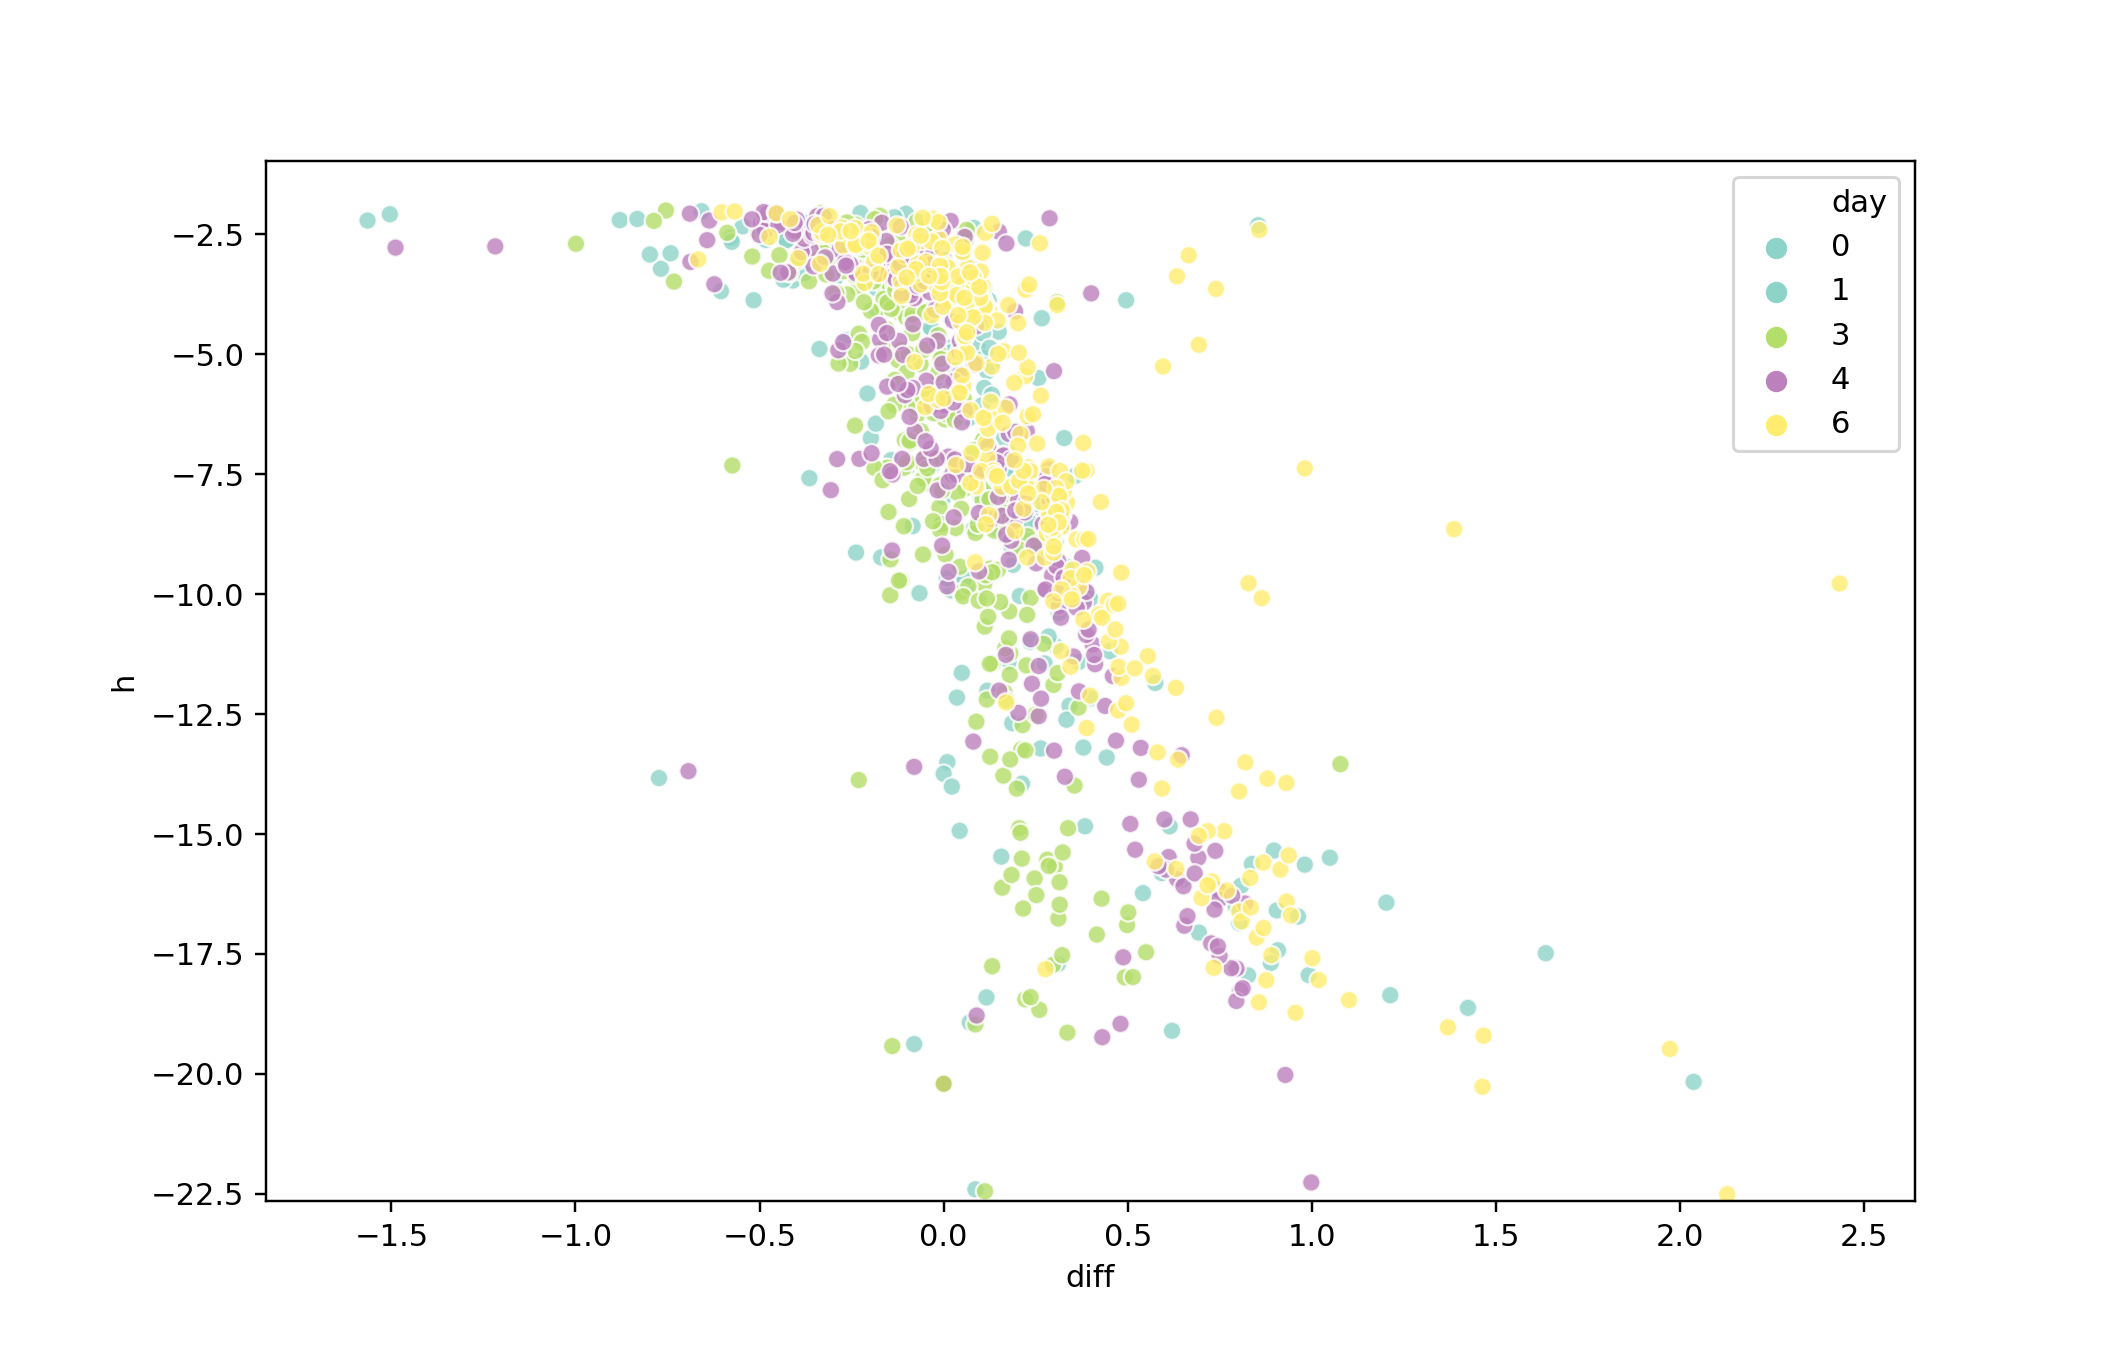

In [63]:
fig,ax = plt.subplots()
sns.scatterplot(x = 'diff', y = 'h', hue = 'day',alpha = 0.8,palette="Set3",data = moce_data)

<IPython.core.display.Javascript object>


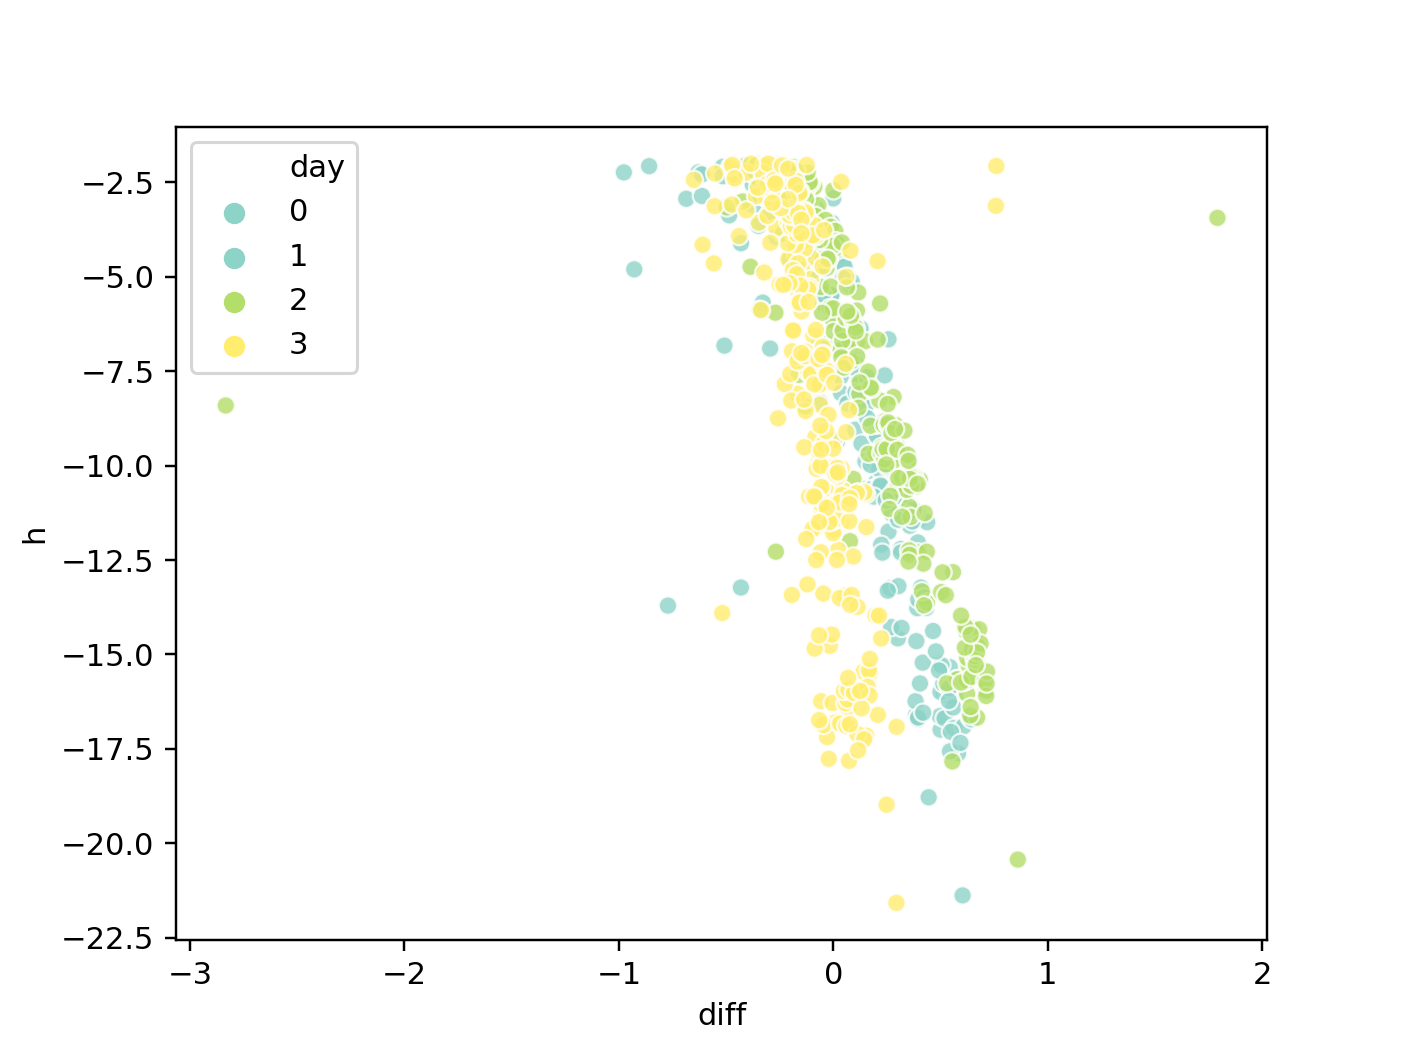

In [62]:
fig,ax = plt.subplots()
sns.scatterplot(x = 'diff', y = 'h', hue = 'day',alpha = 0.8,palette="Set3",data = oil_datum)

<IPython.core.display.Javascript object>


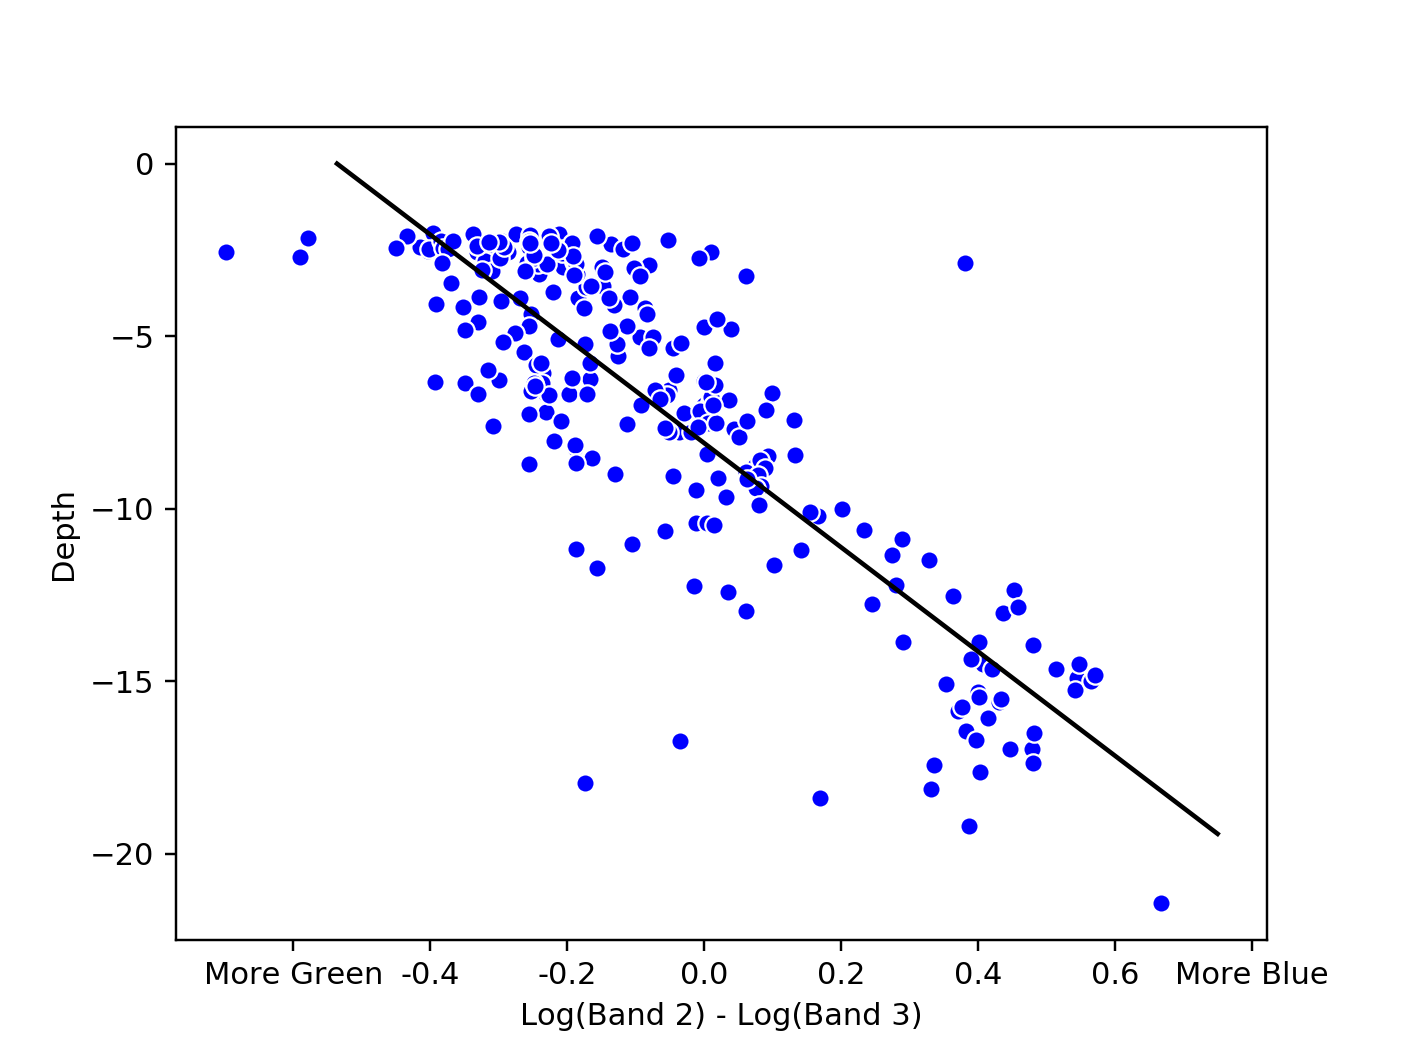

[-0.8, -0.6000000000000001, -0.4, -0.19999999999999996, 0.0, 0.19999999999999996, 0.40000000000000013, 0.6000000000000001, 0.8]
[-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
[-0.8, 'More Green', -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 'More Blue']


In [148]:
corr_plot(rmoce_data)

In [17]:
meta15['reef_name'] = 'Moce'

<IPython.core.display.Javascript object>


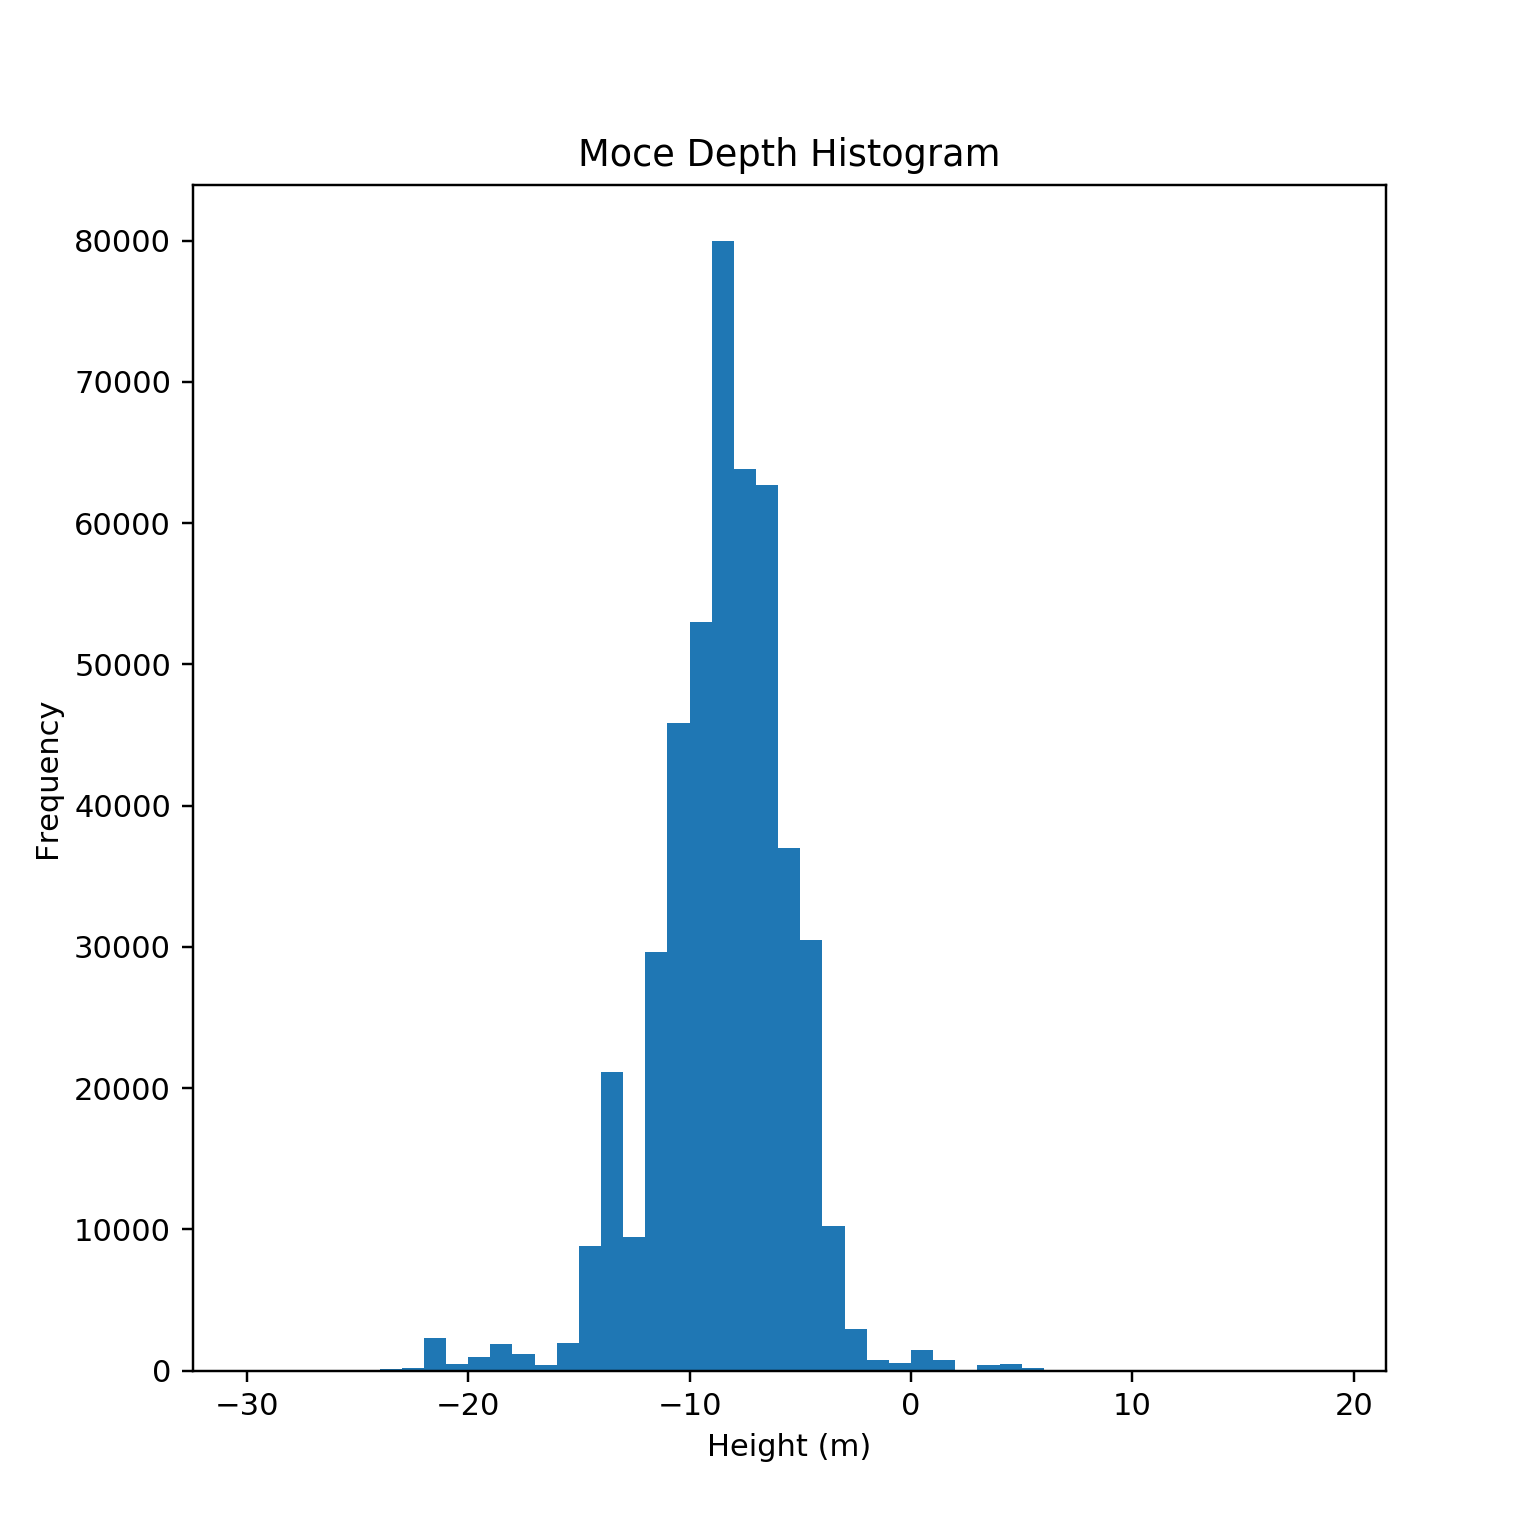

<IPython.core.display.Javascript object>


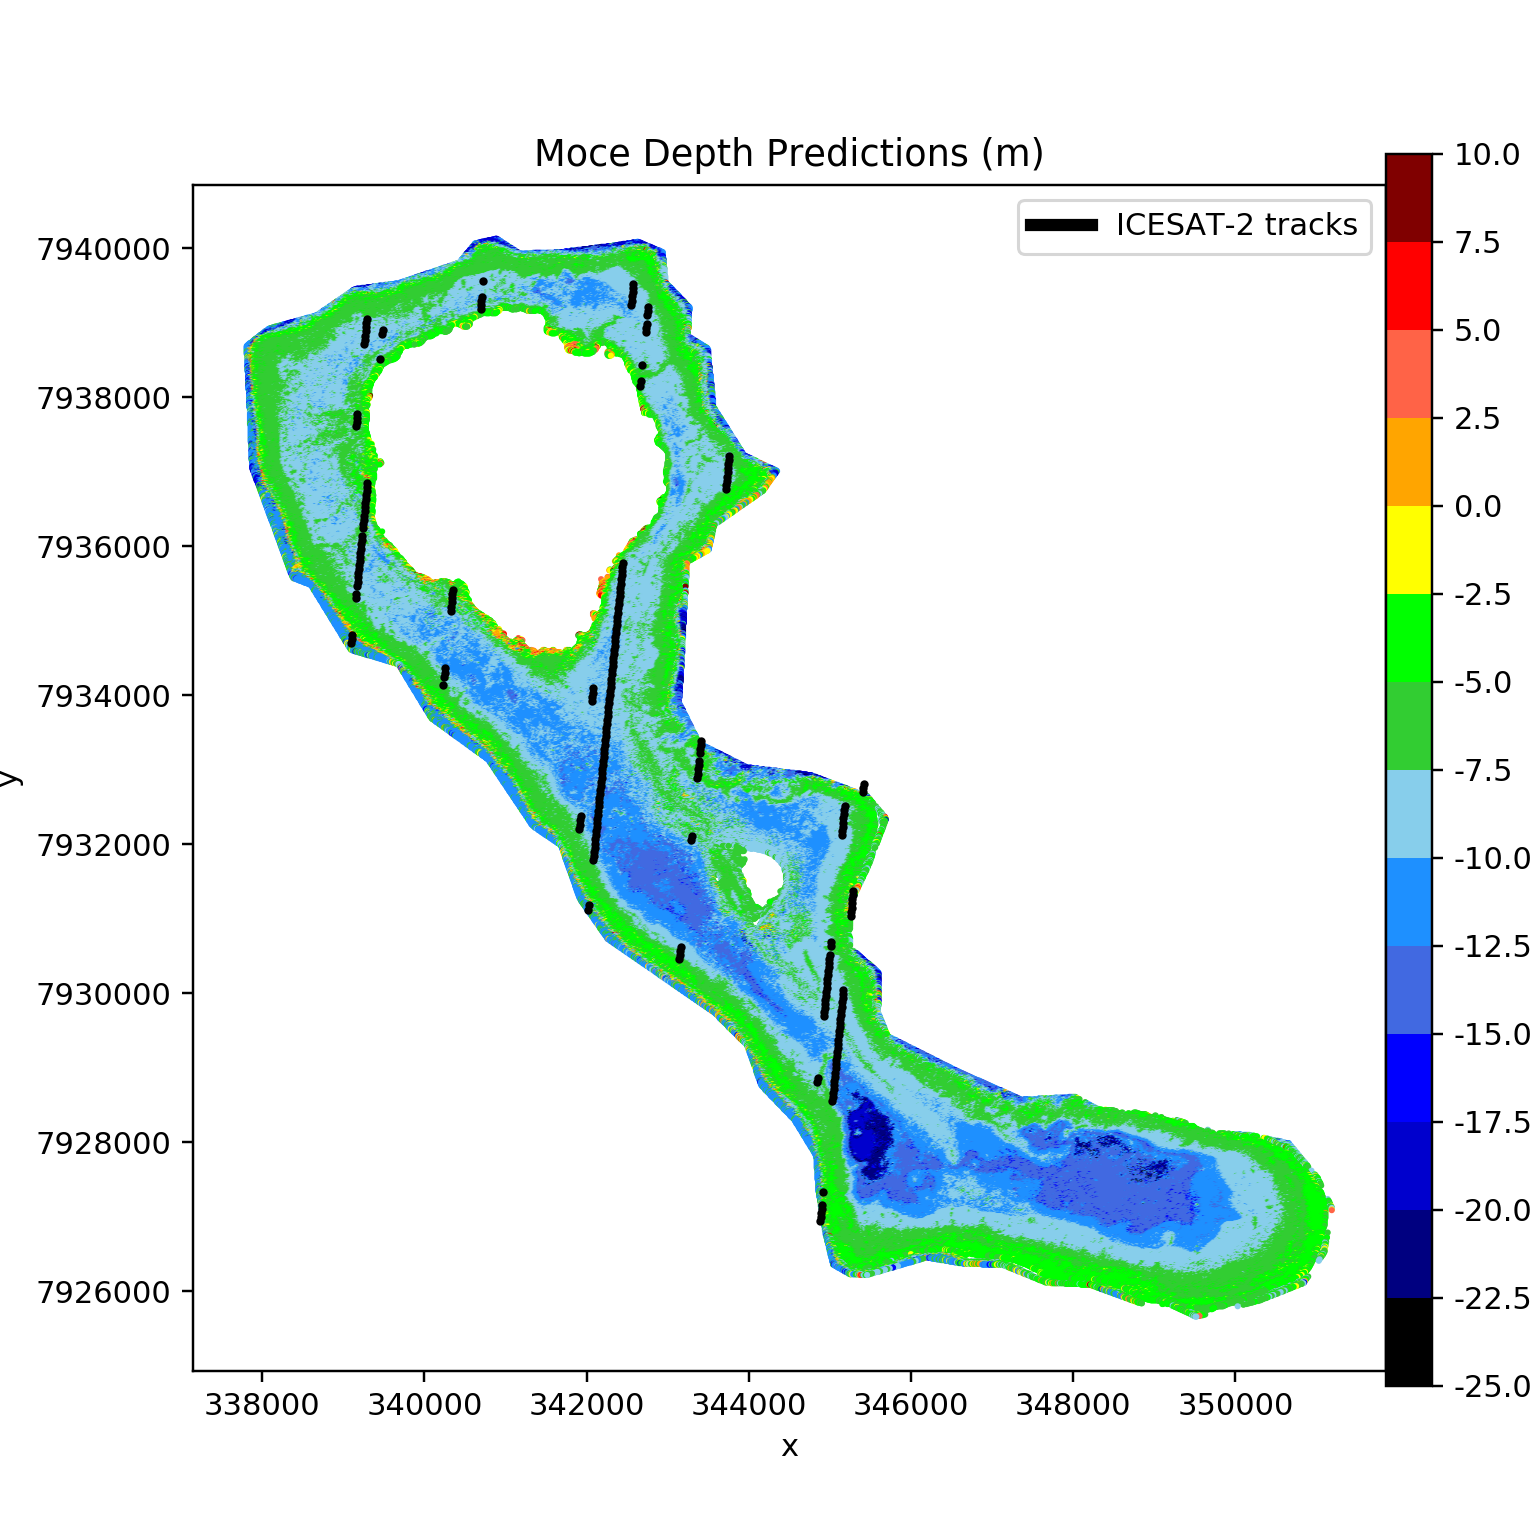

9.101937906251624 -24.51643700578024


In [154]:
#saving all the reef prediction filenames 
fp1 = 'Nasau_out_20190715221115.csv'
fp2 = 'Nasau_out_20190605221114.csv'
fp3 = 'Nasau_out_20190516221115.csv'
fp4 = 'Nasau_out_20190215221106.csv'
fp5 = 'Nasau_out_20190615221114.csv'
fp6 = 'Nasau_out_20190411221108.csv'
fp7 = 'Nasau_out_20190809221110.csv'
fp8 = 'Nasau_out_20181217221101.csv'
fp9 = 'Nasau_out_20181127221102.csv'
fp10 = 'Nasau_out_20160327220957.csv'
fp11 = 'Nasau_out_20180312220910.csv'
fp12 = 'Nasau_out_20180506220921.csv'
fp13 = 'Nasau_out_20161023221051.csv'
fp14 = 'Nasau_out_20180121220911.csv'
fp15 = 'Nasau_out_20161112220917.csv'

#loading in the dataframe 
df_fp = os.path.join('data','Nasau','Output',fp1)
df_nas = pd.read_csv(df_fp)

plot_reefs(df_nas,data15,meta15)

In [160]:
m['reef_name'] = 'Ono-i-Lau'

<IPython.core.display.Javascript object>


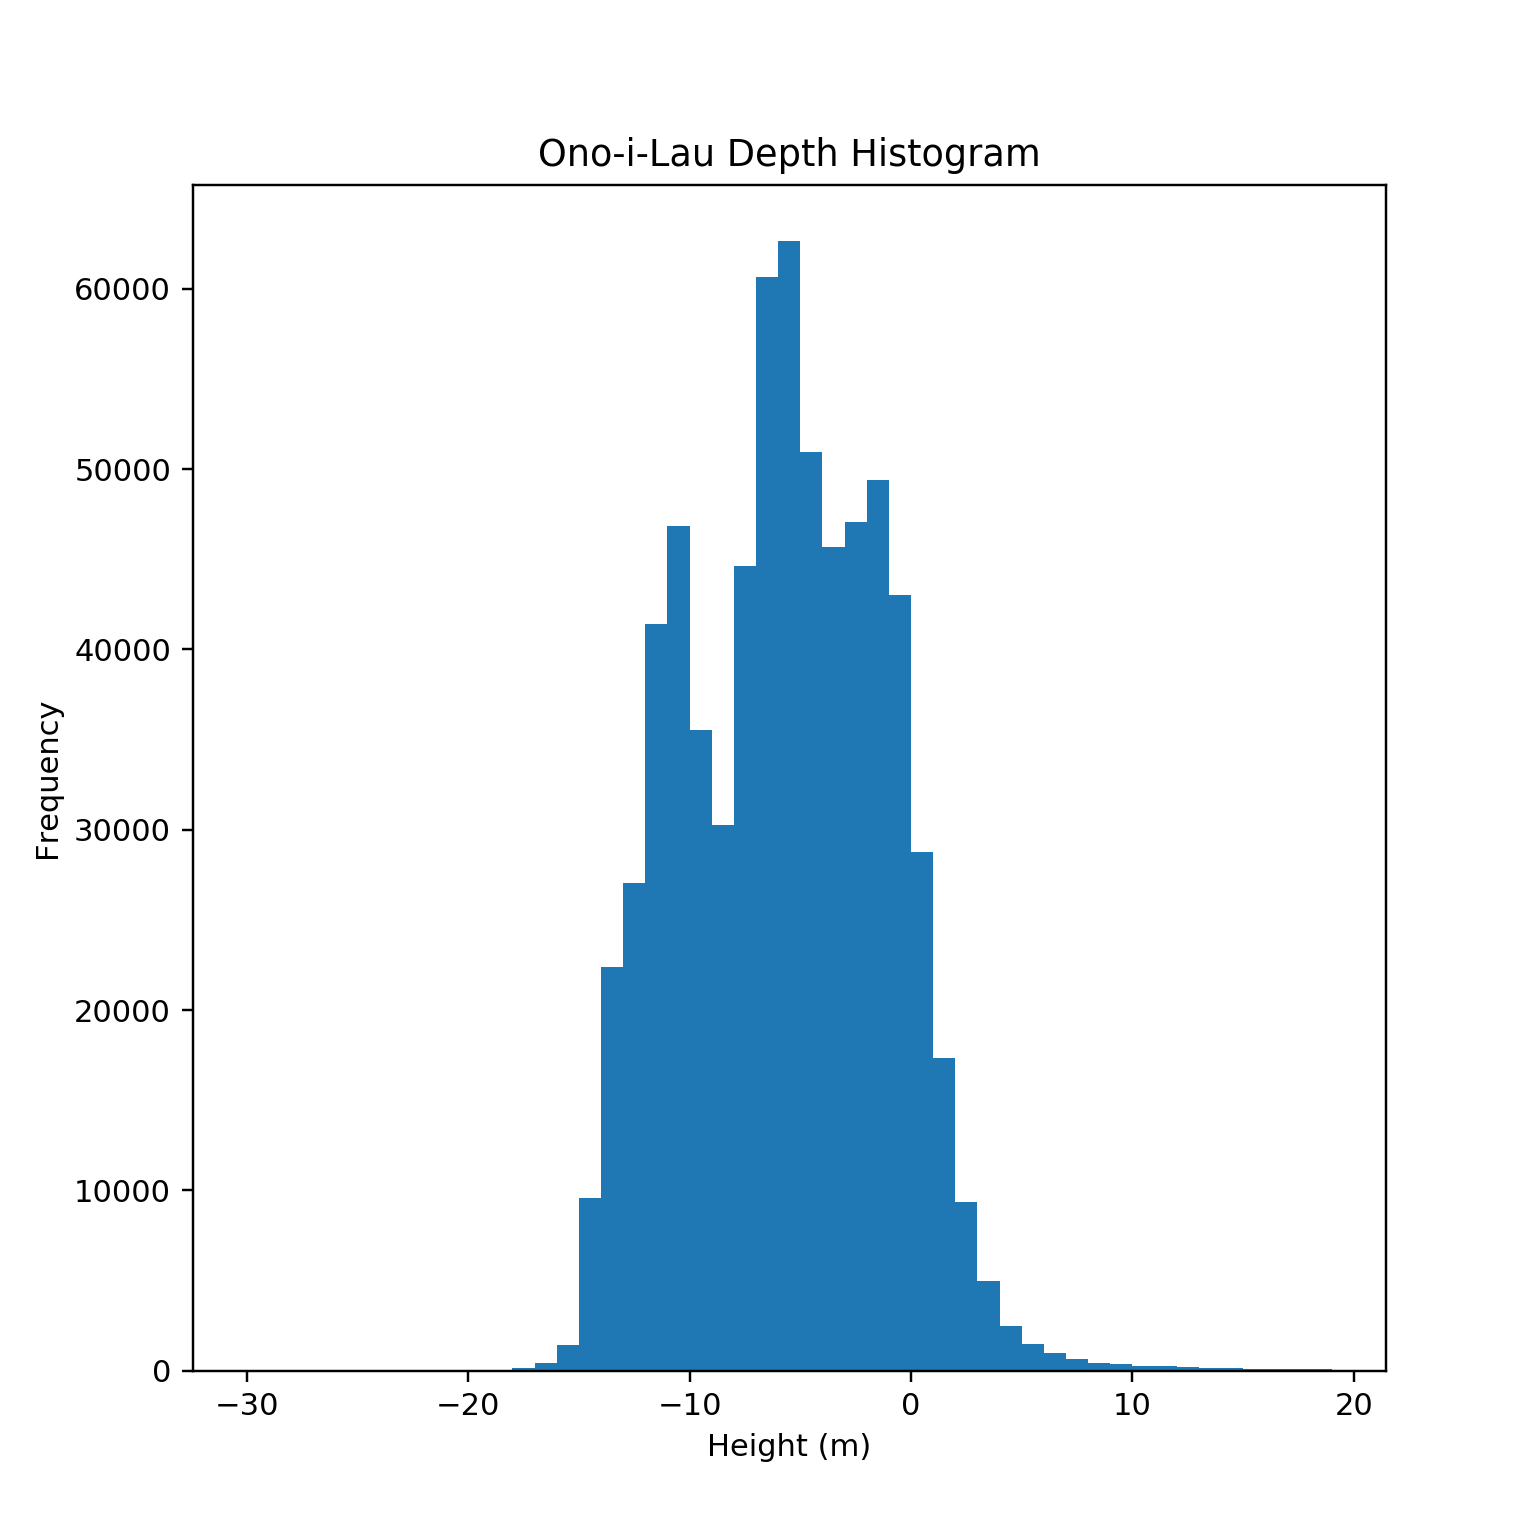

<IPython.core.display.Javascript object>


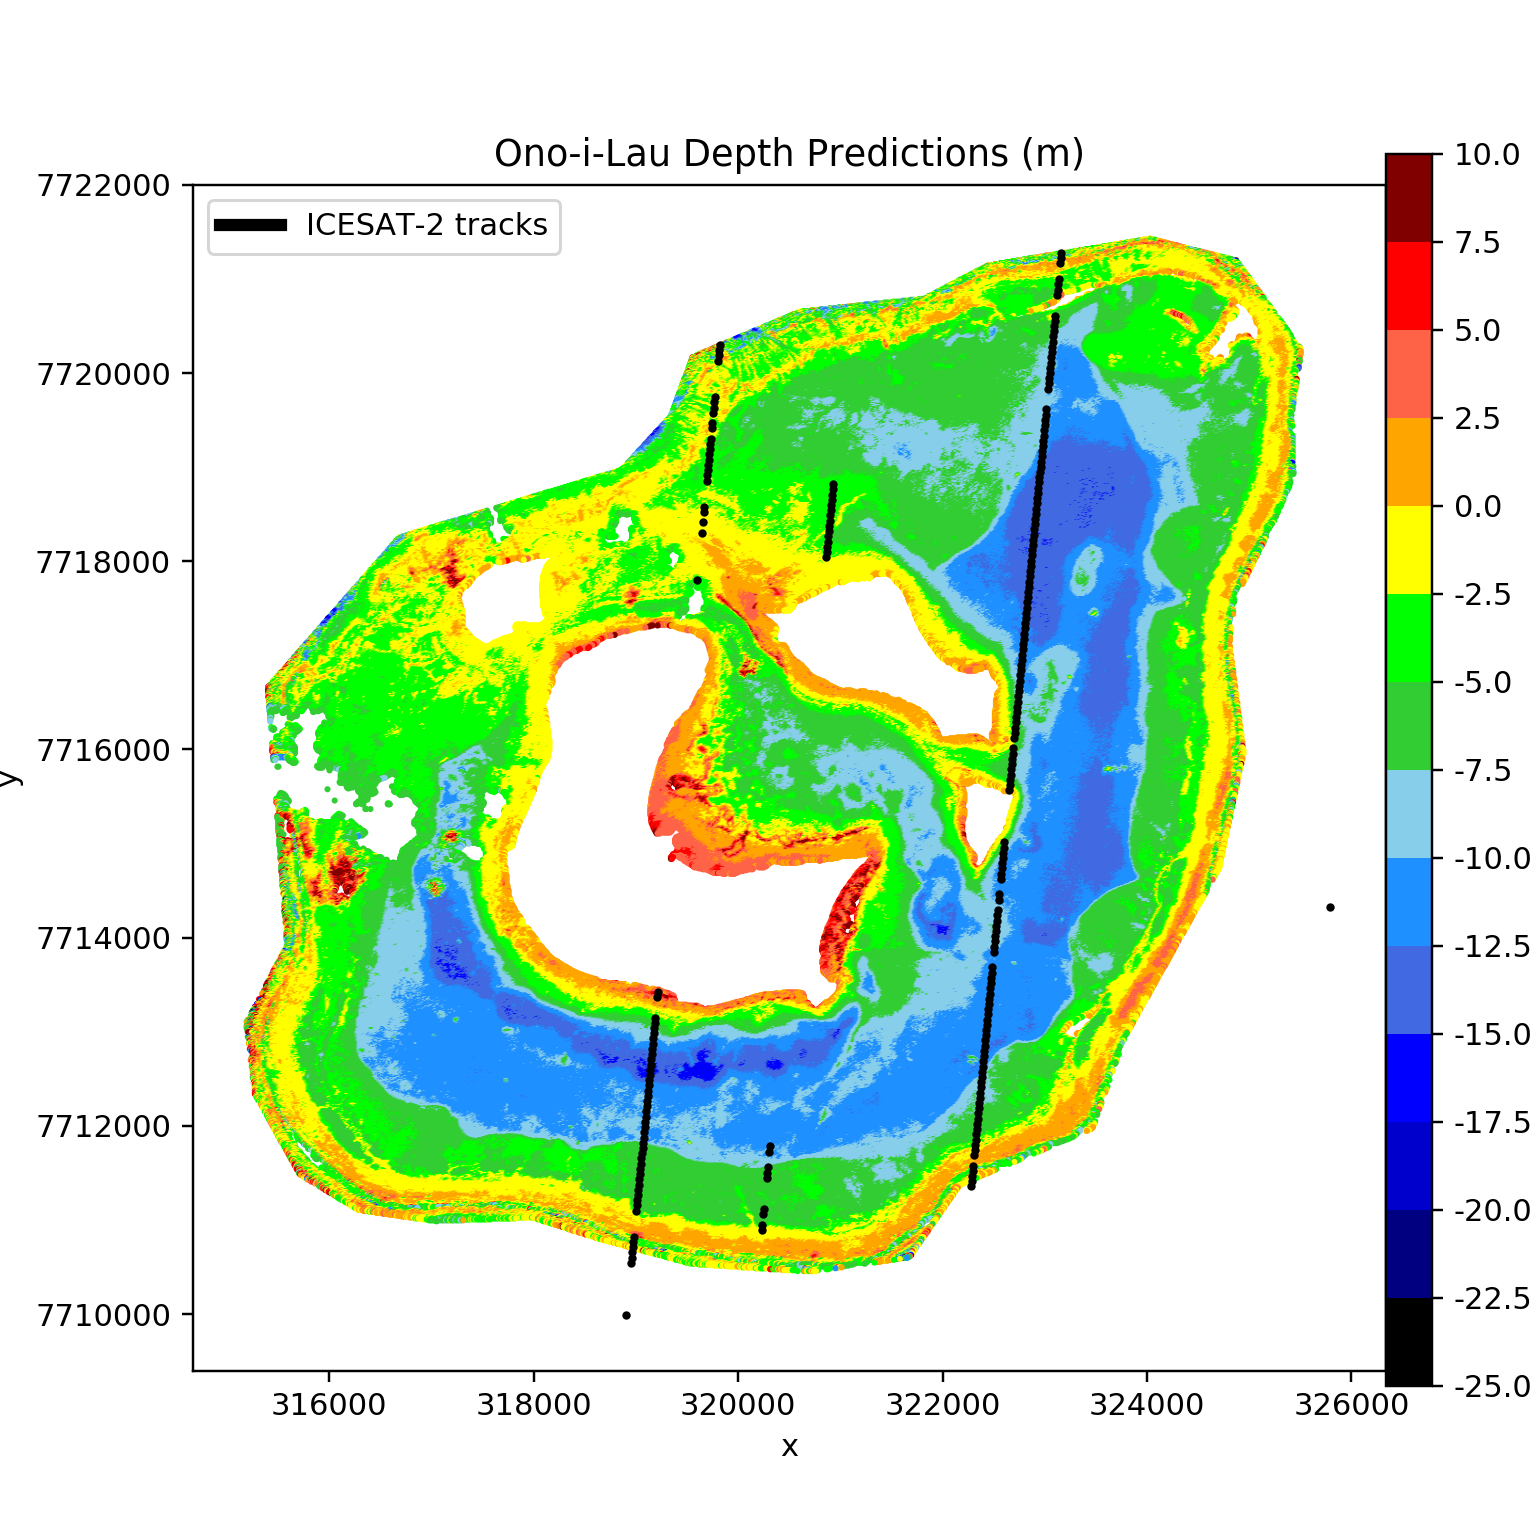

9.996760780877514 -24.502470793771614


In [161]:
out = 'One-i-Lau_out_20190411221138.csv'
df_fp = os.path.join('data','One-i-Lau','Output',out)
df_oil = pd.read_csv(df_fp)

plot_reefs(df_oil,d,m)